# Multi-label Patent Classification with Neural Networks

In [58]:
# import packages 
import tensorflow as tf
import pandas as pd  
import numpy as np 
import gzip
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, Embedding, Reshape, Flatten, Conv1D, Conv2D, MaxPool2D, GlobalMaxPool1D, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras import utils
from keras import optimizers, models
from sklearn import model_selection, preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the Data

Dataset: 

https://www.google.com/googlebooks/uspto-patents-grants-text.html#2015

The parsing and preprocessing of the patent files can be found here: 

https://github.com/cpapadimitriou/W266-Final-Project/blob/master/preparation/parse_xml.py

In [71]:
# load data 

# features 
current_dir = %pwd
abstract = pd.read_table(current_dir+'/out_zipped/docNumberToAbsText.txt.gz',compression='gzip', header=None)
abstract = abstract[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'abstract'})

claim = pd.read_table(current_dir+'/out_zipped/docNumberToClaimText.txt.gz',compression='gzip',  header=None)
claim = claim[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'claim'})

desc = pd.read_table(current_dir+'/out_zipped/docNumberToDescText.txt.gz',compression='gzip', header=None)
desc = desc[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'desc'})

title = pd.read_table(current_dir+'/out_zipped/docNumberToInvTitle.txt.gz',compression='gzip', header=None)
title = title[0].str.split('|', expand=True).rename(columns={0:'doc_num',1:'title'})

file_name = pd.read_table(current_dir+'/out_zipped/fileNameToDocNumber.txt.gz',compression='gzip', header=None)
file_name = file_name[0].str.split('|', expand=True).rename(columns={0:'file_name',1:'doc_num'})


# labels 
labels = pd.read_table(current_dir+'/out_zipped/docNumberToLabelSubClass.txt.gz',compression='gzip', header=None)
labels = labels[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

clas = pd.read_table(current_dir+'/out_zipped/docNumberToClassText.txt.gz',compression='gzip', header=None)
clas = clas[0].str.split('|', expand=True).rename(columns={0:'doc_num'})

### Data Preparation

In [72]:
# joining the datasets
X = pd.concat([title.set_index('doc_num'), 
           abstract.set_index('doc_num'), 
           claim.set_index('doc_num'), 
           desc.set_index('doc_num')], axis=1).sort_index() #  join='inner'

Y = labels.set_index('doc_num').sort_index() #.set_index(X.index) # fixing the index mismatch
Y.columns=["label{}".format(i) for i in range(1,15)] # renaming columns 

print(X.shape)
print(Y.shape)

(25000, 4)
(25000, 14)


In [73]:
# data cleaning 
assert Y['label1'].isnull().sum() == 0 # there is no document with 

print("{} documents with null title".format(X['title'].isnull().sum()))
print("{} documents with null claims".format(X['claim'].isnull().sum()))
print("{} documents with null abstract".format(X['abstract'].isnull().sum()))
print("{} documents with null description".format(X['desc'].isnull().sum()))

# remove documents with null sections (title and abstract)
X_clean = X.dropna(how='any')
null_idx = X[~X.index.isin(X_clean.index)].index # storing the removed indices (i.e. document numbers)
assert X.shape[0] - null_idx.shape[0] == X_clean.shape[0] # making sure the row counts match

# removing the documents with null sections from the labels as well 
Y_clean = Y.loc[X_clean.index]

# some checks
assert X_clean.shape[0] == Y_clean.shape[0]
assert ((Y_clean.index == X_clean.index)*1).sum() == X_clean.shape[0]

# lower-casing everything
X_clean = X_clean.apply(lambda x: x.str.lower())
Y_clean = Y_clean.apply(lambda x: x.str.lower())

0 documents with null title
0 documents with null claims
0 documents with null abstract
0 documents with null description


In [74]:
print(X_clean.shape)
print(Y_clean.shape)

(25000, 4)
(25000, 14)


In [75]:
X_clean.head()

,title,abstract,claim,desc
doc_num,,,,
00100004,planarization apparatus and method,a polishing stage is mounted on a body provide...,"a planarization apparatus (10, 152, 192), comp...",the present invention relates generally to a p...
00100005,image downsampling using redundant pixel removal,a method and apparatus for digital image downs...,"a method of downsampling a digital image , com...",this invention pertains generally to digital i...
00100008,electric power variation compensating device,a compound system of a wind power generation a...,an electric power variation compensating devic...,background of the invention 1. field of the in...
00100009,die for tubular film extrusion,"a die for the extrusion of tubular film, of a ...","a die for the extrusion of tubular film, of a ...",this invention proposes a die for the extrusio...
00100010,stencil printer,disclosed herein is a stencil printer includin...,a stencil printer comprising: the stencil prin...,background of the invention this invention rel...


In [76]:
Y_clean.head()

,label1,label2,label3,label4,label5,label6,label7,label8,label9,label10,label11,label12,label13,label14
doc_num,,,,,,,,,,,,,,
00100004,semiconductor devices; electric solid state de...,"machines, devices, or processes for grinding o...",None,None,None,None,None,None,None,None,None,None,None,None
00100005,"image data processing or generation, in general","pictorial communication, e.g. television",None,None,None,None,None,None,None,None,None,None,None,None
00100008,wind motors,circuit arrangements or systems for supplying ...,None,None,None,None,None,None,None,None,None,None,None,None
00100009,shaping or joining of plastics; shaping of sub...,None,None,None,None,None,None,None,None,None,None,None,None,None
00100010,"apparatus or devices for manifolding, duplicat...",None,None,None,None,None,None,None,None,None,None,None,None,None


In [77]:
# creating data set 
# in this first pass we will concat the text of all patent sections 
# for labels we will use the first label only 

data = pd.DataFrame()
data['full_text'] = X_clean['title'] + " " + X_clean['claim'] + " " + X_clean['abstract'] + " " + X_clean['desc']
data['label1'] = Y_clean['label1']

In [78]:
data

,full_text,label1
doc_num,,
00100004,planarization apparatus and method a planariza...,semiconductor devices; electric solid state de...
00100005,image downsampling using redundant pixel remov...,"image data processing or generation, in general"
00100008,electric power variation compensating device a...,wind motors
00100009,die for tubular film extrusion a die for the e...,shaping or joining of plastics; shaping of sub...
00100010,stencil printer a stencil printer comprising: ...,"apparatus or devices for manifolding, duplicat..."
00100018,system containing a plurality of drams and a b...,electric digital data processing
00100023,a method of manufacturing coverings and a cove...,shaping or joining of plastics; shaping of sub...
00100027,high-frequency switch a high-frequency switch ...,transmission
00100028,a dual mode drum brake device a dual mode drum...,couplings for transmitting rotation


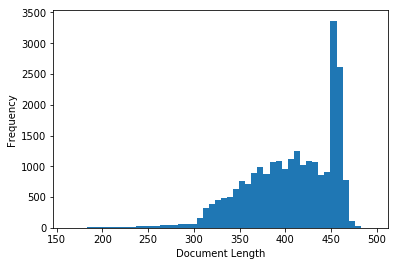

In [154]:
# histogram of document length 
doc_lenghts = data.full_text.str.split().apply(lambda x: len(x))
plt.hist(doc_lenghts, bins=50)
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

In [152]:
# examing the document length 
print("Average document length: {} words".format(round(np.mean(doc_lenghts))))
print("Median document length: {} words".format(round(np.median(doc_lenghts))))
print("Max document length: {} words".format(round(np.max(doc_lenghts))))
print("Min document length: {} words".format(round(np.min(doc_lenghts))))

Average document length: 406 words
Median document length: 413.0 words
Max document length: 496 words
Min document length: 163 words


### Train Test Split

In [155]:
# train test split 
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data['full_text'], data['label1'], test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(20000,)
(5000,)
(20000,)
(5000,)


### Encoding Labels

In [82]:
# encode the target variable 
encoder = preprocessing.LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_test = encoder.fit_transform(Y_test)

#pd.Series(Y_train).value_counts(sort=True)

Y_train

array([127, 240, 406, ..., 124, 539, 245])

### Word Embeddings

**Load the pre-trained embeddings using this command:**

`nohup curl -O https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip > curl.nohup.out 2>&1 &`

Check loading progress with this: `cat curl.nohup.out`

Unzipping the file with python: 

In [68]:
current_dir

'/home/c.papadimitriou/W266-Final-Project'

In [70]:
import zipfile
zip_ref = zipfile.ZipFile('/home/c.papadimitriou/wiki-news-300d-1M.vec.zip', 'r')
zip_ref.extractall('/home/c.papadimitriou/')
zip_ref.close()

In [156]:
# sequence length is set to 480 based on the doc length histogram above 
sequence_length = 480
embedding_dim = 300

In [84]:
# word-embeddings: representing documents using a dense vector representation
# Word embeddings can be trained using the input corpus itself or 
# can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec

# step 1. Loading the pretrained word embeddings
embeddings_index = {}
for i, line in enumerate(open('../wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [157]:
# step 2. Creating a tokenizer object using Keras preprocessing object 
# the tokenizer has a default filter that removes all punctuation, plus tabs and line breaks, minus the ' character.
token = text.Tokenizer()
token.fit_on_texts(data['full_text'])
word_index = token.word_index

In [158]:
#word_index

In [159]:
print('Number of words in our vocabulary: {}'.format(len(word_index.keys())))

Number of words in our vocabulary: 72113


In [160]:
# step 3. Transforming text documents to sequence of tokens and padding them to ensure equal length vectors
# choosing the median document length as max length for padding 
X_train_seq = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=sequence_length)
X_test_seq = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=sequence_length)

In [170]:
print(X_train_seq.shape)
print(X_test_seq.shape)

(20000, 480)
(5000, 480)


In [171]:
# step 4. Creating a mapping of tokens and their respective embeddings
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [173]:
embedding_matrix.shape

(72114, 300)

In [174]:
X_train_seq.shape

(20000, 480)

### CNN model

In [337]:
# Define Parameters 
batch_size = 32
epochs = 2

vocabulary_size = len(word_index) + 1
sequence_length = sequence_length
embedding_dim = embedding_dim
num_filters = 100
kernel_size = 3 # 3 by emb dim 
units = pd.Series(Y_train).value_counts().shape[0]

In [338]:
# Input Layer
input_layer = Input(shape=(sequence_length,), dtype='int32')

# Word embedding Layer
embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length, 
                            weights=[embedding_matrix], trainable=False)(input_layer)
embedding_layer = SpatialDropout1D(0.3)(embedding_layer)

# Convolutional Layer
conv_layer = Conv1D(num_filters, kernel_size=kernel_size, activation="relu")(embedding_layer)

# Pooling Layer
pooling_layer = GlobalMaxPool1D()(conv_layer)

# Output Layers
output_layer1 = Dense(50, activation="relu")(pooling_layer)
output_layer1 = Dropout(0.25)(output_layer1)
output_layer2 = Dense(units= units, activation="softmax")(output_layer1)

# Compile the model
model = models.Model(inputs=input_layer, outputs=output_layer2,)
model.compile(optimizer=optimizers.Adam(lr=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 2580)              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 2580, 300)         21435600  
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 2580, 300)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2578, 100)         90100     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
__________

In [336]:
pd.Series(Y_train).value_counts().shape[0]

532

In [55]:
from keras.utils import to_categorical
y_binary = to_categorical(Y_train)
y_binary.shape


NameError: name 'Y_train' is not defined

In [340]:
# Training 
history = model.fit(X_train_seq, y_binary,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


Train on 16637 samples, validate on 1849 samples
Epoch 1/2
16637/16637 [==============================] - 556s 33ms/step - loss: 5.3057 - acc: 0.0538 - val_loss: 5.1717 - val_acc: 0.0562
Epoch 2/2
16637/16637 [==============================] - 717s 43ms/step - loss: 5.1757 - acc: 0.0546 - val_loss: 5.1681 - val_acc: 0.0562


## Model 

In [ ]:
# define parameters
batch_size = 32
epochs = 2

In [ ]:
# simple fully connected layer NN

model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])


In [ ]:
# fit